In [2]:
from scipy.stats import levene,ttest_ind
from scipy import stats
import re
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 500
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None

In [3]:
## 특문 제거용 함수
def cleanText(readData):
 
    #텍스트에 포함되어 있는 특수 문자 제거
 
    text = re.sub('[-=+#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    text = text.replace(" ","")
    return text

def cleanText2(readData):
 
    #텍스트에 포함되어 있는 특수 문자 제거
 
    text = re.sub('[[\]]', '', readData)
 
    return text

In [4]:
## 일반 user
users = pd.read_csv("users.csv")
users["UID"] = users["_id"].str.replace('ObjectId','').apply(lambda x: cleanText(x)) ## ObjectId 형태 바꿔주기

# 직원분들 아이디 제거
no_member = ['743658034', 'CEO@entcrowd.com', 'mojomoth@gmail.com']
users = users[~users["profile.email"].isin(no_member)]

In [5]:
## 멤버십 user
membership_users = pd.read_csv("membership_users.csv")
# user 회원 대상 membership 여부 컬럼 만들기
uid_list = list(membership_users["UID"])
users['membership_NY'] = users['UID'].apply(lambda x: "Y" if x in uid_list else "N")

In [6]:
users['membership_NY'].value_counts()

N    122620
Y       230
Name: membership_NY, dtype: int64

In [7]:
#users.to_csv("users_membership_YN.csv",index=False,encoding='utf-8-sig',sep=';')

In [8]:
users.head()

,_id,profile.email,profile.name,profile.gender,profile.birth,profile.loginDate,follow.artists,follow.places,follow.genres,follow.concerts,device.kind,alim.push,alim.kakaotalk,alim,area,alim.artist,alim.event,alim.news,alim.venue,UID,membership_NY
0,ObjectId(548bc1f7b0822935db0fae08),rightsna@gmail.com,나세원,NaN,NaN,NaN,"[""568ce1076b038b4c667389b3"",""568ce1076b038b4c6...","[""1100000000""]",[],"[""58e7505b6b038b191180a335"",""565c0dd26b038b4b1...",NaN,Y,NaN,"{""push"":""Y"",""email"":""Y""}",NaN,NaN,NaN,NaN,NaN,548bc1f7b0822935db0fae08,N
1,ObjectId(548bd7d06b038b2d6169d6ea),sjkim@entcrowd.com,NaN,NaN,NaN,NaN,[],"[""1100000000""]",[],[],NaN,Y,NaN,"{""push"":""Y""}",NaN,NaN,NaN,NaN,NaN,548bd7d06b038b2d6169d6ea,N
2,ObjectId(548bdffe6b038bdd7969d6ee),jhjung@entcrowd.com,정주형,NaN,NaN,NaN,"[""5a3fd2c7a144eb5a95219790"",""568ce1076b038b4c6...","[""1100000000""]",[],"[""561c6f586b038b8f59c7d0fd"",""565c0dd26b038b4b1...",android,Y,NaN,"{""push"":""Y"",""email"":""Y""}",NaN,NaN,NaN,NaN,NaN,548bdffe6b038bdd7969d6ee,N
3,ObjectId(548e293b6b038b550db06ae8),j5709gi@hanmail.net,NaN,NaN,NaN,NaN,[],"[""1100000000""]",[],[],NaN,Y,NaN,"{""push"":""Y""}",NaN,NaN,NaN,NaN,NaN,548e293b6b038b550db06ae8,N
4,ObjectId(54ab92f8b0822935db0fae0f),comroi@naver.com,NaN,NaN,NaN,NaN,"[""568ce1076b038b4c6673891a""]","[""1100000000""]",[],"[""550e1d966b038baf28c915cb""]",NaN,Y,NaN,"{""push"":""Y""}",NaN,NaN,NaN,NaN,NaN,54ab92f8b0822935db0fae0f,N


In [9]:
users_2 = users[['UID','profile.email','follow.artists','follow.places','follow.genres','follow.concerts','alim.push','alim',
                 'alim.kakaotalk','area','alim.artist','alim.event','alim.news','alim.venue','membership_NY']]

In [10]:
users_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122850 entries, 0 to 122852
Data columns (total 15 columns):
UID                122850 non-null object
profile.email      122850 non-null object
follow.artists     122849 non-null object
follow.places      122850 non-null object
follow.genres      121525 non-null object
follow.concerts    122850 non-null object
alim.push          122850 non-null object
alim               122850 non-null object
alim.kakaotalk     13745 non-null object
area               0 non-null float64
alim.artist        1015 non-null object
alim.event         1268 non-null object
alim.news          1362 non-null object
alim.venue         1339 non-null object
membership_NY      122850 non-null object
dtypes: float64(1), object(14)
memory usage: 15.0+ MB


In [11]:
users.isnull().sum()

_id                       0
profile.email             0
profile.name          28308
profile.gender        95449
profile.birth        114269
profile.loginDate    122850
follow.artists            1
follow.places             0
follow.genres          1325
follow.concerts           0
device.kind           37512
alim.push                 0
alim.kakaotalk       109105
alim                      0
area                 122850
alim.artist          121835
alim.event           121582
alim.news            121488
alim.venue           121511
UID                       0
membership_NY             0
dtype: int64

----------------------------------------------------------------

## 1) 멤버십 회원 VS 일반 회원 follow 수 비교

In [12]:
def follow_mod(df_col):
    df_col = df_col.astype(str).apply(lambda x: cleanText(x)) ## 불필요한 특문 제거
    df_col = df_col.astype(str).apply(lambda x: "" if x == 'nan' else x)
    df_col = df_col.astype(str).apply(lambda x: x.split(",") if len(x) != 0 else [])

    # follow 한 숫자 count 
    new_col_name = df_col.name+".num"
    users_2[new_col_name] = df_col.apply(lambda x: len(x))
    
    return df_col

In [13]:
users_2['follow.artists'] = follow_mod(users_2['follow.artists'])
users_2['follow.places'] = follow_mod(users_2['follow.places'])
users_2['follow.genres'] = follow_mod(users_2['follow.genres'])
users_2['follow.concerts'] = follow_mod(users_2['follow.concerts'])

In [17]:
users_2['membership_NY'].value_counts()

N    122620
Y       230
Name: membership_NY, dtype: int64

##### 멤버십 회원 VS 일반 회원의 follow 평균/표준편차

In [15]:
users_2.groupby("membership_NY").mean() #평균

,area,follow.artists.num,follow.places.num,follow.genres.num,follow.concerts.num
membership_NY,,,,,
N,NaN,3.088012,1.013668,0.089463,0.293101
Y,NaN,8.265217,0.956522,0.182609,0.852174


In [18]:
# t-test
follow_list = ['follow.artists.num','follow.places.num','follow.genres.num','follow.concerts.num']
for i in follow_list:
    equal_var = True
    group_n = np.array(users_2[users_2['membership_NY']=='N'][i])
    group_y = np.array(users_2[users_2['membership_NY']=='Y'][i])
    
    statistic_1,pvalue_1 = levene(group_n,group_y)
    
    print("="*35)
    if pvalue_1<0.05:
        equal_var = False
    statistic_2, p_value_2 = ttest_ind(a=group_n, b=group_y, equal_var=equal_var)
    
    print(i,"t-test")
    print(f"statistic: {statistic_2:.5f}")
    print(f"p_value  : {p_value_2:.5f}")
    print("="*35)
    print("\t")

follow.artists.num t-test
statistic: -2.99388
p_value  : 0.00276
	
follow.places.num t-test
statistic: 0.70960
p_value  : 0.47796
	
follow.genres.num t-test
statistic: -3.64275
p_value  : 0.00033
	
follow.concerts.num t-test
statistic: -3.67432
p_value  : 0.00030
	


## 2) 첫등록 - 첫결제까지 평균 소요시간(멤버십 공연용 결제)
1) 멤버십 log 가운데 buy_ticket 이력 있는 멤버십 회원만 추려냄(멤버십 회원 가운데 구매 이력이 없는 사람도 있기 때문)

2) 각 회원별로 CREATE_DATE 기준 정렬, 가장 첫번째 등록 시간대 로그 선별

3) 각 회원별로 CREATE_dATe 기준 정렬, 가장 첫번째 buy_ticket 로그 이력 선별

4) 2)에서 3)까지 걸린 시간 계산 및 평균 구하기

In [6]:
first_enroll_buy = pd.read_csv("sql_modify/first_enroll_buy.csv")
first_enroll_buy['CREATE_DATE'] = first_enroll_buy['CREATE_DATE'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
first_enroll_buy = first_enroll_buy.sort_values(["UID","CREATE_DATE"])

In [5]:
first_enroll_buy

,SEQ,LOG_NUMBER,UID,STATUS,AMOUNT,CREATE_DATE,ITEM_CODE,TICKET_CODE,ranking
0,634,log1579758007E1vnxk,580755edb772b1547a9826b3,single_enroll,34000,2020-01-23 14:40:08,NaN,NaN,1
136,635,log1579758669TLtAlU,580755edb772b1547a9826b3,buy_ticket,0,2020-01-23 14:51:09,NaN,NaN,1
1,642,log1579769782cKmnda,5aa1d689a75fa6f4848c652c,single_enroll,39000,2020-01-23 17:56:23,NaN,NaN,1
137,643,log1579769925IkTU4y,5aa1d689a75fa6f4848c652c,buy_ticket,231000,2020-01-23 17:58:46,NaN,NaN,1
2,595,log15797370435AzViD,5ad6d78ba75fa6f48401b3f3,single_enroll,39000,2020-01-23 08:50:44,NaN,NaN,1
138,596,log1579737188YtqLX3,5ad6d78ba75fa6f48401b3f3,buy_ticket,231000,2020-01-23 08:53:09,NaN,NaN,1
3,142,log1574668394FgUbxn,5ad706e2a75fa6f48402853d,twin_enroll,75000,2019-11-25 16:53:15,NaN,NaN,1
139,199,log1575348158HTDIa8,5ad706e2a75fa6f48402853d,buy_ticket,0,2019-12-03 13:42:38,NaN,NaN,1
4,308,log1576728465pvYDEA,5bb6ba456b038bc11ff58a47,twin_enroll,75000,2019-12-19 13:07:46,NaN,NaN,1
140,309,log1576765403zMI097,5bb6ba456b038bc11ff58a47,buy_ticket,0,2019-12-19 23:23:23,NaN,NaN,1


In [12]:
first_enroll_buy["STATUS"].value_counts()

buy_ticket       136
single_enroll     99
twin_enroll       36
upgrade            1
Name: STATUS, dtype: int64

In [13]:
first_enroll_buy[first_enroll_buy["STATUS"]=='upgrade']

,SEQ,LOG_NUMBER,UID,STATUS,AMOUNT,CREATE_DATE,ITEM_CODE,TICKET_CODE,ranking
62,434,log1578565635314DE9,5e04269a6b038b1e19ae105c,upgrade,36000,2020-01-09 19:27:17,NaN,NaN,1


In [14]:
first_enroll_buy = first_enroll_buy[~(first_enroll_buy['UID']=='5e04269a6b038b1e19ae105c')].reset_index(drop=True) 
##가장 첫번째 log가 upgrade 인 회원 제외

In [15]:
first_enroll_buy["STATUS"].value_counts()

buy_ticket       135
single_enroll     99
twin_enroll       36
Name: STATUS, dtype: int64

In [238]:
first_enroll_buy.head(6)

,SEQ,LOG_NUMBER,UID,STATUS,AMOUNT,CREATE_DATE,ITEM_CODE,TICKET_CODE,ranking
0,634,log1579758007E1vnxk,580755edb772b1547a9826b3,single_enroll,34000,2020-01-23 14:40:08,NaN,NaN,1
136,635,log1579758669TLtAlU,580755edb772b1547a9826b3,buy_ticket,0,2020-01-23 14:51:09,NaN,NaN,1
1,642,log1579769782cKmnda,5aa1d689a75fa6f4848c652c,single_enroll,39000,2020-01-23 17:56:23,NaN,NaN,1
137,643,log1579769925IkTU4y,5aa1d689a75fa6f4848c652c,buy_ticket,231000,2020-01-23 17:58:46,NaN,NaN,1
2,595,log15797370435AzViD,5ad6d78ba75fa6f48401b3f3,single_enroll,39000,2020-01-23 08:50:44,NaN,NaN,1
138,596,log1579737188YtqLX3,5ad6d78ba75fa6f48401b3f3,buy_ticket,231000,2020-01-23 08:53:09,NaN,NaN,1


In [17]:
difference = first_enroll_buy['CREATE_DATE'].diff()

In [18]:
mem_diff = []
for i in range(len(difference)):
    if i % 2 == 1:
        mem_diff.append(difference[i])

In [19]:
np.array(mem_diff).mean() ## 첫 등록~첫 결제까지 걸린 평균 시간: 4일 13시간(실 결제가 이루어진 135명 대상)

Timedelta('4 days 13:40:24.385185')

In [32]:
## UID - 시간차이 계산 df csv파일로 만들기
UID = first_enroll_buy.groupby("UID").mean().reset_index()['UID']
pd.concat([UID,pd.DataFrame(mem_diff)],1).to_csv("time_diff.csv",index=False)

#### 시간 데이터 이상치 제거(IQR)

In [242]:
min_diff = []
for i in range(len(mem_diff)):
    difference = mem_diff[i].total_seconds()/60 #분단위
    min_diff.append(difference)

In [243]:
min_diff_df = pd.DataFrame(min_diff)
min_diff_df.describe()

,0
count,135.000000
mean,6580.406420
std,19000.686668
min,0.583333
25%,5.550000
50%,15.566667
75%,811.333333
max,110893.100000


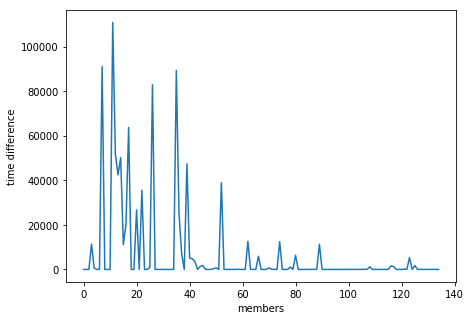

In [309]:
plt.figure(figsize=(7,5))
plt.xlabel("members")
sns.lineplot(x = min_diff_df.index, y = min_diff_df[0])
plt.ylabel("time difference")
plt.show()

In [268]:
q1 = min_diff_df[0].quantile(0.25)
q3 = min_diff_df[0].quantile(0.75)

down = q1-1.5*(q3-q1) ##최솟값(down~q1)
up = q3+1.5*(q3-q1) ##최댓값(q3~up)

In [269]:
count = min_diff_df[(min_diff_df[0]>down)&(min_diff_df[0]<up)][0].count()
mean = min_diff_df[(min_diff_df[0]>down)&(min_diff_df[0]<up)][0].mean()

print("="*40)
print("이상치 제거 건 수: ",count)
print("이상치 제거 건들의 평균: 약",round(mean),"분")
print("="*40)

이상치 제거 건 수:  109
이상치 제거 건들의 평균: 약 135.0 분


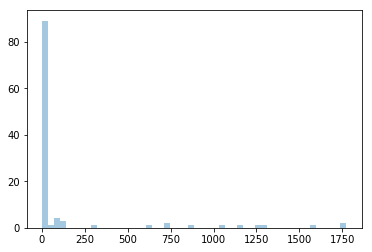

In [317]:
sns.distplot(min_diff_df[(min_diff_df[0]>down)&(min_diff_df[0]<up)],kde=False)

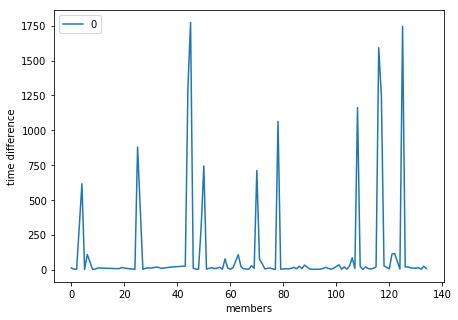

In [316]:
plt.figure(figsize=(7,5))
plt.xlabel("members")
sns.lineplot(data = min_diff_df[(min_diff_df[0]>down)&(min_diff_df[0]<up)])
plt.ylabel("time difference")
plt.show()

-----------

## 결제내역 EDA

In [10]:
df = pd.read_csv('sql_modify/membership_pay_info_by_order.csv', sep=';')
df.head()

,ORDERNO,ITEM_CODE,ITEM_NAME,ITEM_QUANTITY,sum(ITEM_AMOUNT),sum(ITEM_COMMISSION),TICKET_CODE,ORDER_ID,ORDER_NAME,ORDER_EMAIL,BASE_REGIST_DT,PAY_COMPLETE_DT,UID
0,1532146870PO1MSL,5b32f14f6b038b374551afe3,더스테이힐링파크 BLUE stage'한 여름 밤 숲속콘서트 with 이루,2,60000.0,2000.0,GRFJ,freshns@hotmail.com,이새봄,freshns@naver.com,2018-07-21 13:22:22,2018-07-21 13:22:22,5ad6d78ba75fa6f48401b3f3
1,15729649283B7VCL,5db926846b038b501269e8bf,스위니토드 - A석 (평일 비지정석),1,0.0,0.0,BSIY,1206935446,박은정(19800904),happyluv1@naver.com,2019-11-05 23:43:13,2019-11-05 23:43:13,5dc17e416b038b0c13f743c2
2,1573039682WWT5NZ,5da072756b038bbb4b87a61c,아이다 - A석(지정석),3,78000.0,0.0,KMGY,1207474808,배연진,bae0231@hanmail.net,2019-11-06 20:29:43,2019-11-06 20:39:01,5dc297a06b038ba549a7d903
3,1573284036XTE2JC,5d9174546b038b5b7f7205f7,노머시페스트10 [nomercy fest vol.10],1,35000.0,1000.0,4JVZ,1209565268,김재중,aton4300@gmail.com,2019-11-09 16:22:09,2019-11-09 16:22:09,5dc6680d6b038ba6749d28d9
4,1573494378GLARJV,5d95de0f6b038b7e0efd562c,레베카-A석(평일 지정석),1,0.0,0.0,FMYC,1208430519,정대한,joyman21@naver.com,2019-11-12 02:47:00,2019-11-12 02:47:00,5dc4421d6b038bac6cf7c456


In [11]:
df.columns

Index(['ORDERNO', 'ITEM_CODE', 'ITEM_NAME', 'ITEM_QUANTITY',
       'sum(ITEM_AMOUNT)', 'sum(ITEM_COMMISSION)', 'TICKET_CODE', 'ORDER_ID',
       'ORDER_NAME', 'ORDER_EMAIL', 'BASE_REGIST_DT', 'PAY_COMPLETE_DT',
       'UID'],
      dtype='object')

PAY_BANK_NAME	329
PAY_BANK_ACCOUNTNO	329

In [12]:
# Col2 ORDERNO
len(df['ORDERNO'])

190

In [13]:
# Col3 ITEM_CODE
# 공연 Object ID (회차)
len(df['ITEM_CODE'].unique())

53

In [14]:
df['ITEM_CODE'].head()

0    5b32f14f6b038b374551afe3
1    5db926846b038b501269e8bf
2    5da072756b038bbb4b87a61c
3    5d9174546b038b5b7f7205f7
4    5d95de0f6b038b7e0efd562c
Name: ITEM_CODE, dtype: object

In [15]:
len(df['ITEM_NAME'].unique())

44

In [16]:
# Col5 ITEM_TOTAL_AMOUNT
df['sum(ITEM_AMOUNT)'].describe()

count       190.000000
mean      48457.894737
std       84604.187770
min           0.000000
25%           0.000000
50%       26000.000000
75%       75000.000000
max      850000.000000
Name: sum(ITEM_AMOUNT), dtype: float64

c:\users\ina lee\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


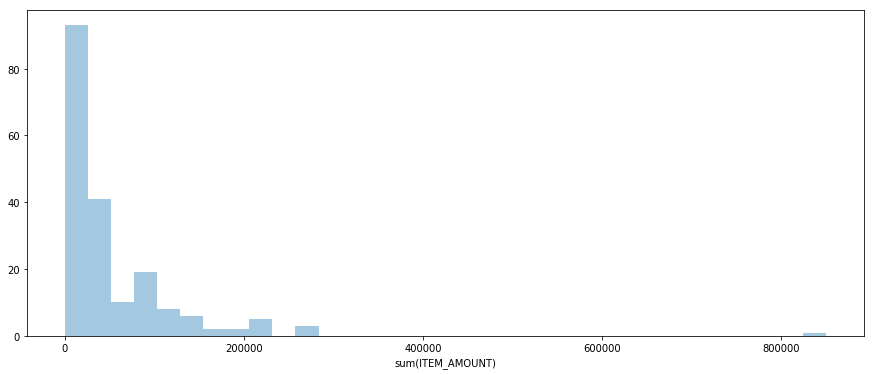

In [17]:
plt.figure(figsize=(15,6))
sns.distplot(df['sum(ITEM_AMOUNT)'],kde=False)

In [18]:
# amount 가 0이 아닌, 추가 결제가 일어난 건 수
len(df[df['sum(ITEM_AMOUNT)'] != 0])

103

In [19]:
# 추가 결제가 일어난, 데이터에 대해서만 통계 확인.
Additional_Payment = df[df['sum(ITEM_AMOUNT)'] != 0]['sum(ITEM_AMOUNT)']
Additional_Payment.describe()

count       103.000000
mean      89388.349515
std       97818.883558
min       13000.000000
25%       39000.000000
50%       65000.000000
75%      105000.000000
max      850000.000000
Name: sum(ITEM_AMOUNT), dtype: float64

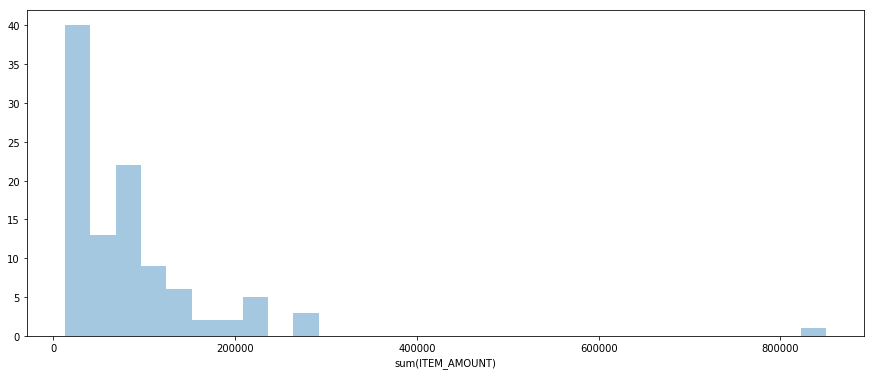

In [20]:
plt.figure(figsize=(15,6))
sns.distplot(Additional_Payment,kde=False)

Text(0.5, 1.0, 'Item Quantity Pie Chart')

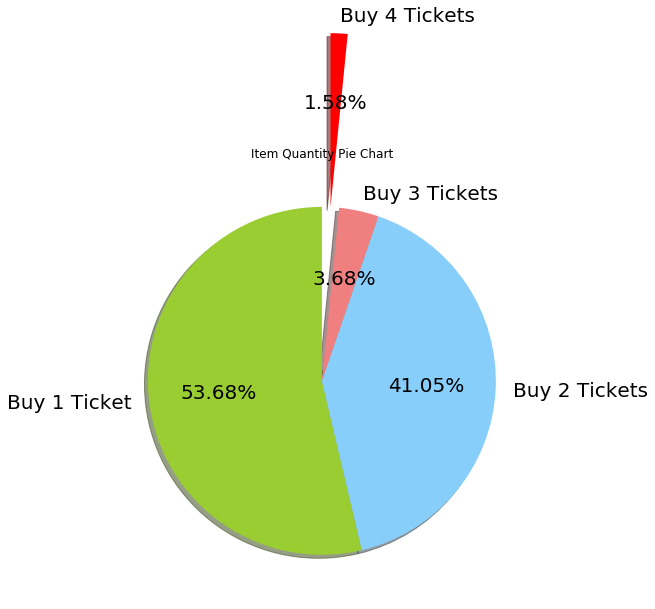

In [21]:
# Pie Chart

Buy_1 = len(df[df['ITEM_QUANTITY'] == 1])
Buy_2 = len(df[df['ITEM_QUANTITY'] == 2])
Buy_3 = len(df[df['ITEM_QUANTITY'] == 3])
Buy_4 = len(df[df['ITEM_QUANTITY'] == 4])

plt.figure(figsize=(10, 8))
Group_Names = ['Buy 1 Ticket', 'Buy 2 Tickets', 'Buy 3 Tickets', 'Buy 4 Tickets']
Group_Sizes = [Buy_1, Buy_2, Buy_3, Buy_4]
Group_Colors = ['yellowgreen', 'lightskyblue', 'lightcoral', 'red']
Group_Explodes = (0, 0, 0, 1)

plt.pie(Group_Sizes,
        explode = Group_Explodes,
        labels  = Group_Names,
        colors  = Group_Colors,
        autopct = '%1.2f%%',
        shadow  = True,
        startangle = 90,
        textprops = {'fontsize': 20}
       )
plt.title('Item Quantity Pie Chart')


In [22]:
# 결제 시간 비교
df['PAY_COMPLETE_DT'] = df['PAY_COMPLETE_DT'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [23]:
week_day = df['PAY_COMPLETE_DT'].apply(lambda x: x.strftime('%A'))
hour = df['PAY_COMPLETE_DT'].apply(lambda x: x.strftime('%H'))

In [24]:
hour.value_counts()

14    19
18    18
17    15
15    15
21    14
13    12
22    11
11    11
19    10
20    10
23    10
12     8
00     7
10     7
16     7
09     4
02     4
07     2
03     2
08     2
05     1
01     1
Name: PAY_COMPLETE_DT, dtype: int64

In [25]:
week_day.value_counts()

Tuesday      37
Wednesday    34
Thursday     31
Monday       25
Saturday     25
Friday       19
Sunday       19
Name: PAY_COMPLETE_DT, dtype: int64

-----------------

### ONLY 멤버십 공연

In [26]:
#데이터 불러오기 및 불필요한 컬럼 제거
concert_data = pd.read_csv("concert_v4.csv")
concert_data.drop("Unnamed: 0",1,inplace=True)
concert_data.rename(columns={"_id":"ITEM_CODE"},inplace=True)

In [27]:
# 멤버십용 공연(subsrive= Y 인 공연) 추려내기
subs_only = concert_data[concert_data['subscribe.service_yn']=='Y'].reset_index(drop=True)

In [28]:
# 결제내역 가운데 멤버십용 공연 여부 확인
merge_v1 = pd.merge(df,subs_only,on="ITEM_CODE",how='left')
## 7개 누락 -> 일반공연

# 누락 발생한 건수(일반공연 결제) 살펴보기
merge_v1[merge_v1['ticket_name'].isnull()]

,ORDERNO,ITEM_CODE,ITEM_NAME,ITEM_QUANTITY,sum(ITEM_AMOUNT),sum(ITEM_COMMISSION),TICKET_CODE,ORDER_ID,ORDER_NAME,ORDER_EMAIL,BASE_REGIST_DT,PAY_COMPLETE_DT,UID,updates,tag,base.title,base.package_code,base.photoURI,base.type,base.view_yn,base.by_site,base.genre,info.createDate,info.modifyDate,info.viewCount,info.version,range.min_timestamp,range.max_timestamp,range.min_price,range.max_price,range.min_discount,range.max_discount,summary.genre,summary.venue,follow,event.content,event.modifyDate,event.yn,recommenders,site_infos,default,summary.lineup,summary.reservation_url,summary.reservation_mobile_url,subscribe.service_yn,subscribe.type,subscribe.amount,dynamicLink,base.recommend_yn,seat_infos,modifyDate,handwriting.lineup,handwriting.venue,handwriting.title,base.resend_yn,base.photoURI2,default.title,default.max_timestamp,default.min_timestamp,default.venue,default.lineup,default.photo_url,default.reservation_url,default.reservation_mobile_url,default.site,base.modify_yn,tags,detail_info,youtube,youtube_ids,range.open_timestamp,base.overlap_yn,subscribe.view_yn,ticket_code,sub_title,genre,grade,timestamp,viewtime,photoURI,send_yn,deadline_timestamp,payment_timestamp,vid,lineups,ticket_type,ticket_name,ticket_price,local_price,commission,seat_code,stop_names,seats,end_timestamp,limit
0,1532146870PO1MSL,5b32f14f6b038b374551afe3,더스테이힐링파크 BLUE stage'한 여름 밤 숲속콘서트 with 이루,2,60000.0,2000.0,GRFJ,freshns@hotmail.com,이새봄,freshns@naver.com,2018-07-21 13:22:22,2018-07-21 13:22:22,5ad6d78ba75fa6f48401b3f3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1573039682WWT5NZ,5da072756b038bbb4b87a61c,아이다 - A석(지정석),3,78000.0,0.0,KMGY,1207474808,배연진,bae0231@hanmail.net,2019-11-06 20:29:43,2019-11-06 20:39:01,5dc297a06b038ba549a7d903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1573284036XTE2JC,5d9174546b038b5b7f7205f7,노머시페스트10 [nomercy fest vol.10],1,35000.0,1000.0,4JVZ,1209565268,김재중,aton4300@gmail.com,2019-11-09 16:22:09,2019-11-09 16:22:09,5dc6680d6b038ba6749d28d9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1574221018EQ6JSB,5da072756b038bbb4b87a61c,아이다 - A석(지정석),1,0.0,0.0,NVGF,1203105966,김현옥,hyunok7107 @naver.com,2019-11-20 12:37:10,2019-11-20 12:37:10,5dba60446b038b1f672516b8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1574302296YAY94X,5db7cc606b038b301b336c6a,롤월당 파티,1,20000.0,1000.0,ZJ4J,1209565268,김재중 (19670426),aton4300@gmail.com,2019-11-21 11:12:39,2019-11-21 11:12:39,5dc6680d6b038ba6749d28d9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1574844560HFFDCV,5da072756b038bbb4b87a61c,아이다 - A석(지정석),1,0.0,0.0,KAYP,dolab5@naver.com,최선미,dolab5@naver.

In [29]:
## membership용 공연만 살펴보기
merge_v2 = pd.merge(df,subs_only,on="ITEM_CODE",how='inner')

In [30]:
# 평균 구매 장수
sum(merge_v2['ITEM_QUANTITY'])/len(merge_v2)

1.53551912568306

In [31]:
merge_v2['sum(ITEM_AMOUNT)'].describe()

count       183.000000
mean      44612.021858
std       62060.208870
min           0.000000
25%           0.000000
50%       26000.000000
75%       74000.000000
max      270000.000000
Name: sum(ITEM_AMOUNT), dtype: float64

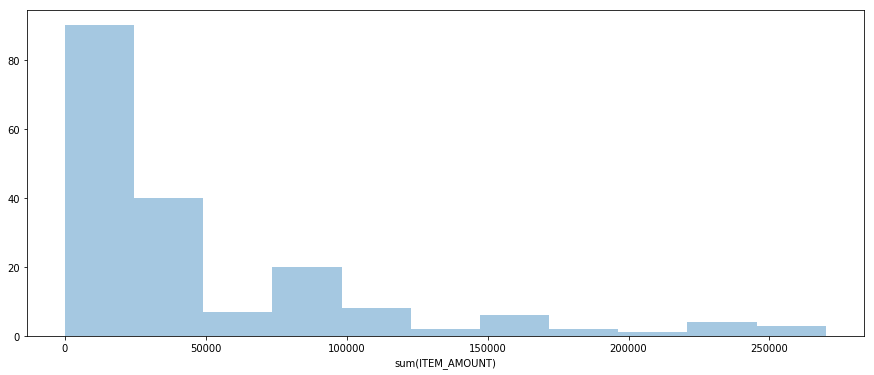

In [32]:
plt.figure(figsize=(15,6))
sns.distplot(merge_v2['sum(ITEM_AMOUNT)'],kde=False)

In [33]:
# 추가 결제가 일어난, 데이터에 대해서만 통계 확인.
Additional_Payment = merge_v2[merge_v2['sum(ITEM_AMOUNT)'] != 0]['sum(ITEM_AMOUNT)']
Additional_Payment.describe()

count        98.000000
mean      83306.122449
std       63006.202961
min       13000.000000
25%       39000.000000
50%       65500.000000
75%      105000.000000
max      270000.000000
Name: sum(ITEM_AMOUNT), dtype: float64

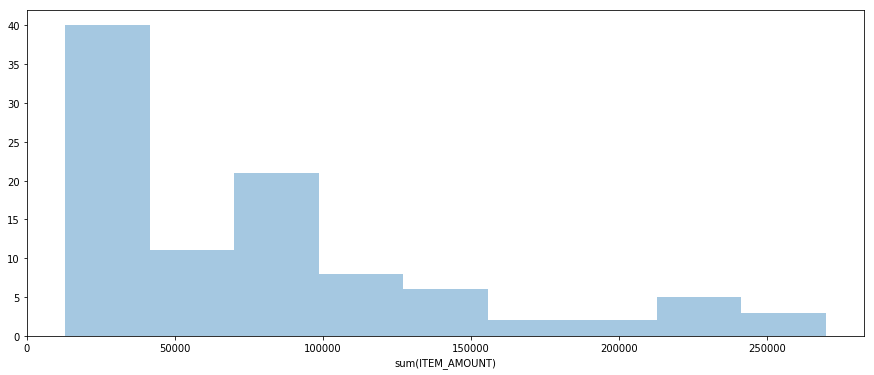

In [34]:
plt.figure(figsize=(15,6))
sns.distplot(Additional_Payment,kde=False)